# Experiment: what happens if we flag out the N2H+ channel?

In [2]:
%matplotlib inline
from casatasks import tclean, ft, clearcal, uvsub, split
from casatools import ms, table, msmetadata
from spectral_cube import SpectralCube
import numpy as np
from astropy import units as u, visualization
from astropy.visualization import simple_norm
import pylab as pl
visualization.quantity_support()
ms = ms()
msmd = msmetadata()
tb = table()

In [3]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L


In [4]:
original_ms = "W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_selfcal.ms"

In [23]:
dec17ms = 'scigoals/W51-E_B3/group.uid___A001_X1296_X106/member.uid___A001_X1296_X10b/calibrated/W51-E_B3_uid___A001_X1296_X10b_continuum_merged.cal.ms'

In [5]:
msmd.open(original_ms)
low_spws = [spw for spw in msmd.spwsforfield('W51-E') if np.all(msmd.chanfreqs(spw) < 9.3e10)]
high_spws = [spw for spw in msmd.spwsforfield('W51-E') if np.all(msmd.chanfreqs(spw) > 9.5e10)]
print(low_spws, high_spws)
msmd.close()

[13, 17, 29, 33, 37, 41, 45] [14, 15, 18, 19, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47]


True

In [38]:
split(vis=original_ms, outputvis='W51-E_B3_selfcal_non2h.ms', spw=','.join(map(str, low_spws + high_spws)), datacolumn='corrected')

True

In [28]:
continuum_ms = dec17ms
selfcal_ms = 'W51-E_B3_dec17_recont.ms'
field='W51-E'

msmd.open(continuum_ms)
fdm_spws = msmd.spwsforfield(field)
assert len(fdm_spws) > 0
bws = msmd.bandwidths()[fdm_spws]
spwstr = ",".join(map(str, fdm_spws))
freqs = [msmd.reffreq(spw)['m0']['value'] for spw in fdm_spws]
chwids = [np.mean(msmd.chanwidths(spw)) for spw in fdm_spws]

# using Roberto's numbers
# https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/performance/fov/bw-smearing
Synth_HPBW = 0.3 # Smallest synth HPBW among target sample in arcsec
#PB_HPBW = 21. * (300. / minfrq) # PB HPBW at lowest band freq (arcsec)
#targetwidth = 0.25 * (Synth_HPBW / PB_HPBW) * minfrq # 98% BW smearing criterion

width = [int(np.abs(0.25 * (Synth_HPBW / (21. * (300e9 / frq))) * frq / chwid))
         for frq, chwid in zip(freqs, chwids)]
# do not allow downsampling below 1/2 original width because that drops
# edge channels sometimes
width = [ww if float(ww)/msmd.nchan(spw) < 0.5 else int(msmd.nchan(spw)/2)
         for ww, spw in zip(width, fdm_spws)]
print(width)

msmd.close()

tb.open(continuum_ms)
if 'CORRECTED_DATA' in tb.colnames():
    datacolumn='corrected'
else:
    datacolumn='data'
tb.close()

split(vis=continuum_ms,
      outputvis=selfcal_ms,
      datacolumn=datacolumn,
      #antenna=antennae,
      spw=spwstr,
      width=width,
      field=field,
     )

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


True

In [34]:
import glob
from casatasks import applycal

In [35]:
cals = glob.glob("W51-E_B3*merged_12M*cal")
applycal(vis=selfcal_ms,
         #gainfield=okfields_list,
         gaintable=cals,
         interp="linear",
         applymode='calonly',
         calwt=False)

In [30]:
ls -d W51-E_B3*cal

W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_amp7_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase1_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase2_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase3_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase4_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase5_int.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase6_int.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_amp7_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_phase1_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_phase2_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_phase3_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_phase4_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_phase5_inf.cal/
W51-E_B3_uid___A001_X1296_X10b_continuum_merged_bsens_12M_phase5_int.cal/
W51-E_B3_u

In [29]:
ls -d W51-E_B3_dec17*

W51-E_B3_dec17_recont.ms/


rm -r imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_non2h_brightmask_dirty*

In [41]:
tclean(vis="W51-E_B3_selfcal_non2h.ms",
       selectdata=True, field="W51-E", spw="", timerange="", uvrange="",
       antenna="DA41,DA42,DA43,DA44,DA45,DA46,DA47,DA49,DA50,DA51,DA52,DA53,DA54,DA55,DA56,DA57,DA58,DA59,DA61,DA62,DA63,DA65,DV01,DV03,DV04,DV06,DV07,DV08,DV09,DV10,DV11,DV12,DV13,DV14,DV15,DV16,DV17,DV19,DV20,DV23,DV24,DV25,PM01,PM02,PM03,DA60,DA64,DV05,DV22,DA48,DA49,DA51,DA60,DV01,DV15,DV23,PM03,PM04,DA53,DA46,DV10,DA42,DA43,DA44,DA45,DA46,DA47,DA50,DA51,DA55,DA56,DA57,DA58,DA61,DA62,DV02,DV03,DV07,DV11,DV12,DV14,DV19,DV21",
       scan="", observation="", intent="", datacolumn="corrected",
       imagename="imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_non2h_brightmask_dirty",
       imsize=[4800,  4800], cell=['0.0375arcsec',  '0.0375arcsec'],
       phasecenter="ICRS 290.934083333deg 14.5081943683deg",
       stokes="I",
       projection="SIN",
       startmodel=['imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt0',
                   'imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt1'],
       specmode="mfs", reffreq="", nchan=-1, start="",
       width="", outframe="LSRK", veltype="radio", restfreq=[],
       interpolation="linear", perchanweightdensity=True, gridder="mosaic",
       facets=1, chanchunks=1, wprojplanes=1, vptable="",
       mosweight=True, aterm=True, psterm=False, wbawp=True, conjbeams=False,
       cfcache="", usepointing=False, computepastep=360.0, rotatepastep=360.0,
       pointingoffsetsigdev=[], pblimit=0.1, normtype="flatnoise",
       deconvolver="mtmfs", scales=[0,  3,  9], nterms=2, smallscalebias=0.0,
       restoration=True, restoringbeam=[], pbcor=True, outlierfile="",
       weighting="briggs", robust=0, noise="1.0Jy", npixels=0, uvtaper=[],
       niter=0, gain=0.1, threshold="0.2mJy", nsigma=0.0, cycleniter=-1,
       cyclefactor=1.0, minpsffraction=0.05, maxpsffraction=0.8,
       interactive=False, usemask="user",
       mask="../reduction/reduction/clean_regions/W51E_Bright.crtf",
       pbmask=0.0,
       sidelobethreshold=3.0, noisethreshold=5.0, lownoisethreshold=1.5,
       negativethreshold=0.0, smoothfactor=1.0, minbeamfrac=0.3,
       cutthreshold=0.01, growiterations=75, dogrowprune=True,
       minpercentchange=-1.0, verbose=False, fastnoise=True, restart=True,
       savemodel="none", calcres=True, calcpsf=True, parallel=False)

{}

In [ ]:
tclean(vis=selfcal_ms,
       selectdata=True, field="W51-E", spw="", timerange="", uvrange="",
       antenna="DA41,DA42,DA43,DA44,DA45,DA46,DA47,DA49,DA50,DA51,DA52,DA53,DA54,DA55,DA56,DA57,DA58,DA59,DA61,DA62,DA63,DA65,DV01,DV03,DV04,DV06,DV07,DV08,DV09,DV10,DV11,DV12,DV13,DV14,DV15,DV16,DV17,DV19,DV20,DV23,DV24,DV25,PM01,PM02,PM03,DA60,DA64,DV05,DV22,DA48,DA49,DA51,DA60,DV01,DV15,DV23,PM03,PM04,DA53,DA46,DV10,DA42,DA43,DA44,DA45,DA46,DA47,DA50,DA51,DA55,DA56,DA57,DA58,DA61,DA62,DV02,DV03,DV07,DV11,DV12,DV14,DV19,DV21",
       scan="", observation="", intent="", datacolumn="corrected",
       imagename="imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_dirty",
       imsize=[4800,  4800], cell=['0.0375arcsec',  '0.0375arcsec'],
       phasecenter="ICRS 290.934083333deg 14.5081943683deg",
       stokes="I",
       projection="SIN",
       startmodel=['imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt0',
                   'imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt1'],
       specmode="mfs", reffreq="", nchan=-1, start="",
       width="", outframe="LSRK", veltype="radio", restfreq=[],
       interpolation="linear", perchanweightdensity=True, gridder="mosaic",
       facets=1, chanchunks=1, wprojplanes=1, vptable="",
       mosweight=True, aterm=True, psterm=False, wbawp=True, conjbeams=False,
       cfcache="", usepointing=False, computepastep=360.0, rotatepastep=360.0,
       pointingoffsetsigdev=[], pblimit=0.1, normtype="flatnoise",
       deconvolver="mtmfs", scales=[0,  3,  9], nterms=2, smallscalebias=0.0,
       restoration=True, restoringbeam=[], pbcor=True, outlierfile="",
       weighting="briggs", robust=0, noise="1.0Jy", npixels=0, uvtaper=[],
       niter=0, gain=0.1, threshold="0.2mJy", nsigma=0.0, cycleniter=-1,
       cyclefactor=1.0, minpsffraction=0.05, maxpsffraction=0.8,
       interactive=False, usemask="user",
       mask="../reduction/reduction/clean_regions/W51E_Bright.crtf",
       pbmask=0.0,
       sidelobethreshold=3.0, noisethreshold=5.0, lownoisethreshold=1.5,
       negativethreshold=0.0, smoothfactor=1.0, minbeamfrac=0.3,
       cutthreshold=0.01, growiterations=75, dogrowprune=True,
       minpercentchange=-1.0, verbose=False, fastnoise=True, restart=True,
       savemodel="none", calcres=True, calcpsf=True, parallel=False)

In [13]:
rm -r imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_non2h_brightmask_clean.*

In [14]:
tclean(vis="W51-E_B3_selfcal_non2h.ms",
       selectdata=True, field="W51-E", spw="", timerange="", uvrange="",
       antenna="DA41,DA42,DA43,DA44,DA45,DA46,DA47,DA49,DA50,DA51,DA52,DA53,DA54,DA55,DA56,DA57,DA58,DA59,DA61,DA62,DA63,DA65,DV01,DV03,DV04,DV06,DV07,DV08,DV09,DV10,DV11,DV12,DV13,DV14,DV15,DV16,DV17,DV19,DV20,DV23,DV24,DV25,PM01,PM02,PM03,DA60,DA64,DV05,DV22,DA48,DA49,DA51,DA60,DV01,DV15,DV23,PM03,PM04,DA53,DA46,DV10,DA42,DA43,DA44,DA45,DA46,DA47,DA50,DA51,DA55,DA56,DA57,DA58,DA61,DA62,DV02,DV03,DV07,DV11,DV12,DV14,DV19,DV21",
       scan="", observation="", intent="", datacolumn="corrected",
       imagename="imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_non2h_brightmask_clean",
       imsize=[4800,  4800], cell=['0.0375arcsec',  '0.0375arcsec'],
       phasecenter="ICRS 290.934083333deg 14.5081943683deg",
       stokes="I",
       projection="SIN",
       startmodel=['imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt0',
                   'imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt1'],
       specmode="mfs", reffreq="", nchan=-1, start="",
       width="", outframe="LSRK", veltype="radio", restfreq=[],
       interpolation="linear", perchanweightdensity=True, gridder="mosaic",
       facets=1, chanchunks=1, wprojplanes=1, vptable="",
       mosweight=True, aterm=True, psterm=False, wbawp=True, conjbeams=False,
       cfcache="", usepointing=False, computepastep=360.0, rotatepastep=360.0,
       pointingoffsetsigdev=[], pblimit=0.1, normtype="flatnoise",
       deconvolver="mtmfs", scales=[0,  3,  9], nterms=2, smallscalebias=0.0,
       restoration=True, restoringbeam=[], pbcor=True, outlierfile="",
       weighting="briggs", robust=0, noise="1.0Jy", npixels=0, uvtaper=[],
       niter=10000, gain=0.1, threshold="0.2mJy", nsigma=0.0, cycleniter=-1,
       cyclefactor=1.0, minpsffraction=0.05, maxpsffraction=0.8,
       interactive=False, usemask="user",
       mask="../reduction/reduction/clean_regions/W51E_Bright.crtf",
       pbmask=0.0,
       sidelobethreshold=3.0, noisethreshold=5.0, lownoisethreshold=1.5,
       negativethreshold=0.0, smoothfactor=1.0, minbeamfrac=0.3,
       cutthreshold=0.01, growiterations=75, dogrowprune=True,
       minpercentchange=-1.0, verbose=False, fastnoise=True, restart=True,
       savemodel="none", calcres=True, calcpsf=True, parallel=False)

{}

In [ ]:
tclean(vis=selfcal_ms,
       selectdata=True, field="W51-E", spw="", timerange="", uvrange="",
       antenna="DA41,DA42,DA43,DA44,DA45,DA46,DA47,DA49,DA50,DA51,DA52,DA53,DA54,DA55,DA56,DA57,DA58,DA59,DA61,DA62,DA63,DA65,DV01,DV03,DV04,DV06,DV07,DV08,DV09,DV10,DV11,DV12,DV13,DV14,DV15,DV16,DV17,DV19,DV20,DV23,DV24,DV25,PM01,PM02,PM03,DA60,DA64,DV05,DV22,DA48,DA49,DA51,DA60,DV01,DV15,DV23,PM03,PM04,DA53,DA46,DV10,DA42,DA43,DA44,DA45,DA46,DA47,DA50,DA51,DA55,DA56,DA57,DA58,DA61,DA62,DV02,DV03,DV07,DV11,DV12,DV14,DV19,DV21",
       scan="", observation="", intent="", datacolumn="corrected",
       imagename="imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean",
       imsize=[4800,  4800], cell=['0.0375arcsec',  '0.0375arcsec'],
       phasecenter="ICRS 290.934083333deg 14.5081943683deg",
       stokes="I",
       projection="SIN",
       startmodel=['imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt0',
                   'imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7.model.tt1'],
       specmode="mfs", reffreq="", nchan=-1, start="",
       width="", outframe="LSRK", veltype="radio", restfreq=[],
       interpolation="linear", perchanweightdensity=True, gridder="mosaic",
       facets=1, chanchunks=1, wprojplanes=1, vptable="",
       mosweight=True, aterm=True, psterm=False, wbawp=True, conjbeams=False,
       cfcache="", usepointing=False, computepastep=360.0, rotatepastep=360.0,
       pointingoffsetsigdev=[], pblimit=0.1, normtype="flatnoise",
       deconvolver="mtmfs", scales=[0,  3,  9], nterms=2, smallscalebias=0.0,
       restoration=True, restoringbeam=[], pbcor=True, outlierfile="",
       weighting="briggs", robust=0, noise="1.0Jy", npixels=0, uvtaper=[],
       niter=10000, gain=0.1, threshold="0.2mJy", nsigma=0.0, cycleniter=-1,
       cyclefactor=1.0, minpsffraction=0.05, maxpsffraction=0.8,
       interactive=False, usemask="user",
       mask="../reduction/reduction/clean_regions/W51E_Bright.crtf",
       pbmask=0.0,
       sidelobethreshold=3.0, noisethreshold=5.0, lownoisethreshold=1.5,
       negativethreshold=0.0, smoothfactor=1.0, minbeamfrac=0.3,
       cutthreshold=0.01, growiterations=75, dogrowprune=True,
       minpercentchange=-1.0, verbose=False, fastnoise=True, restart=True,
       savemodel="none", calcres=True, calcpsf=True, parallel=False)

In [6]:
finaliter_prefix = "imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_non2h_brightmask_dirty"

Text(0.5, 1.0, 'model.tt1')

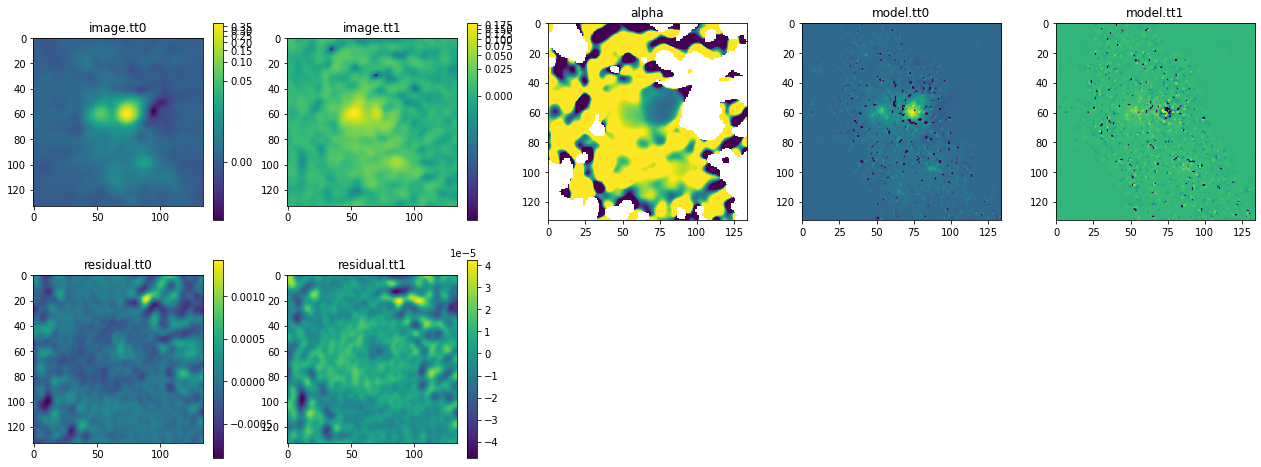

In [7]:
cutoutregion = 'fk5; box(19:23:43.93,+14:30:34.8,5",5")'
pl.figure(figsize=(22,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,1).imshow(image[0].value, norm=simple_norm(image[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt0")
imagett1 = SpectralCube.read(f'{finaliter_prefix}.image.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,2).imshow(imagett1[0].value, norm=simple_norm(imagett1[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt1")
residual = SpectralCube.read(f'{finaliter_prefix}.residual.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,6).imshow(residual[0].value, norm=simple_norm(residual[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt0")
residualtt1 = SpectralCube.read(f'{finaliter_prefix}.residual.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,7).imshow(residualtt1[0].value, norm=simple_norm(residualtt1[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt1")
alpha = SpectralCube.read(f'{finaliter_prefix}.alpha', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,3).imshow(alpha[0].value, norm=simple_norm(alpha[0].value, stretch='linear', min_cut=-2, max_cut=4));
pl.title("alpha")
model = SpectralCube.read(f'{finaliter_prefix}.model.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,4).imshow(model[0].value, norm=simple_norm(model[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt0")
modeltt1 = SpectralCube.read(f'{finaliter_prefix}.model.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,5).imshow(modeltt1[0].value, norm=simple_norm(modeltt1[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt1")

Text(0.5, 1.0, 'model.tt1')

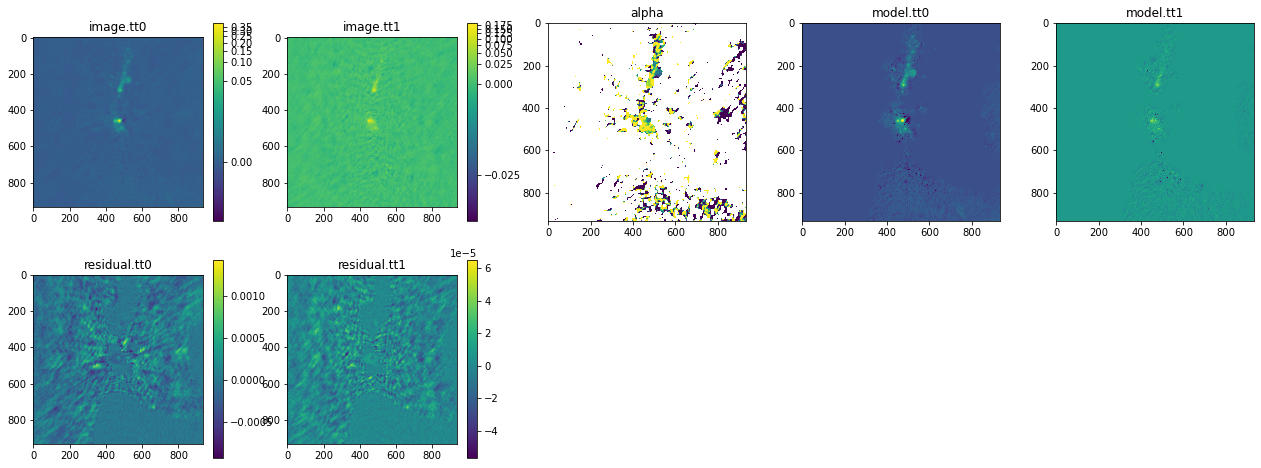

In [8]:
cutoutregion = 'fk5; box(19:23:43.93,+14:30:34.8,35",35")'
pl.figure(figsize=(22,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,1).imshow(image[0].value, norm=simple_norm(image[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt0")
imagett1 = SpectralCube.read(f'{finaliter_prefix}.image.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,2).imshow(imagett1[0].value, norm=simple_norm(imagett1[0].value, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("image.tt1")
residual = SpectralCube.read(f'{finaliter_prefix}.residual.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,6).imshow(residual[0].value, norm=simple_norm(residual[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt0")
residualtt1 = SpectralCube.read(f'{finaliter_prefix}.residual.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,7).imshow(residualtt1[0].value, norm=simple_norm(residualtt1[0].value, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])
pl.title("residual.tt1")
alpha = SpectralCube.read(f'{finaliter_prefix}.alpha', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,3).imshow(alpha[0].value, norm=simple_norm(alpha[0].value, stretch='linear', min_cut=-2, max_cut=4));
pl.title("alpha")
model = SpectralCube.read(f'{finaliter_prefix}.model.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,4).imshow(model[0].value, norm=simple_norm(model[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt0")
modeltt1 = SpectralCube.read(f'{finaliter_prefix}.model.tt1', format='casa_image').subcube_from_ds9region(cutoutregion)
pl.subplot(2,5,5).imshow(modeltt1[0].value, norm=simple_norm(modeltt1[0].value, stretch='log', max_percent=99.995, min_percent=1));
pl.title("model.tt1")

In [9]:
pipeline_pfx = "imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter"
pipe_image = SpectralCube.read(f'{pipeline_pfx}.image.tt0', format='casa_image')

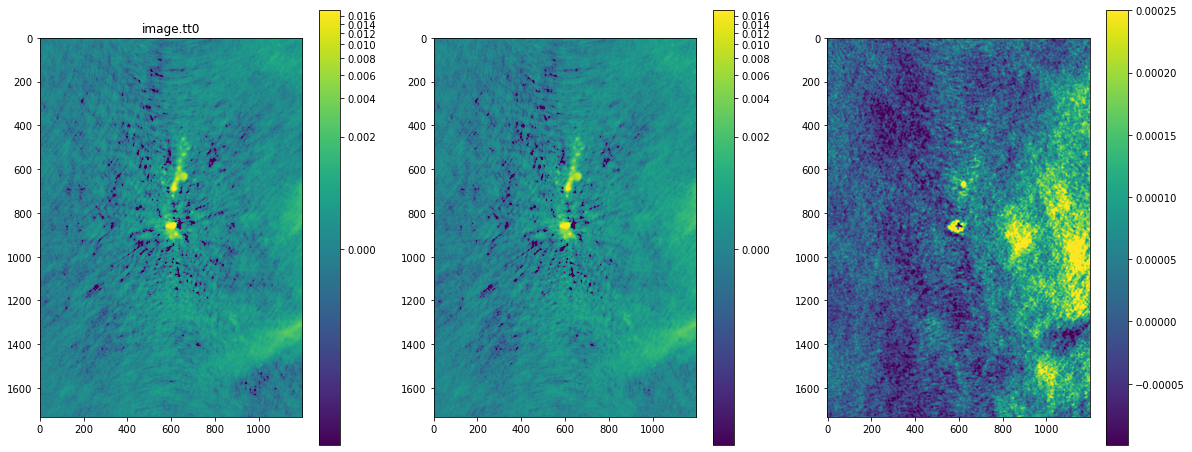

In [10]:
cutoutregion = 'fk5; box(19:23:43.93,+14:30:34.8,45",65")'

pl.figure(figsize=(20,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
ax1 = pl.subplot(1,3,1)
ax1.imshow(image[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax1.set_title("image.tt0")
ax2 = pl.subplot(1,3,2)
im2 = pipe_image.subcube_from_ds9region(cutoutregion)
ax2.imshow(im2[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax3 = pl.subplot(1,3,3)
im3 = im2[0].value-image[0].value
ax3.imshow(im3, norm=simple_norm(im3, max_percent=99, min_percent=1, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])

In [15]:
finaliter_prefix = "imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_non2h_brightmask_clean"
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)

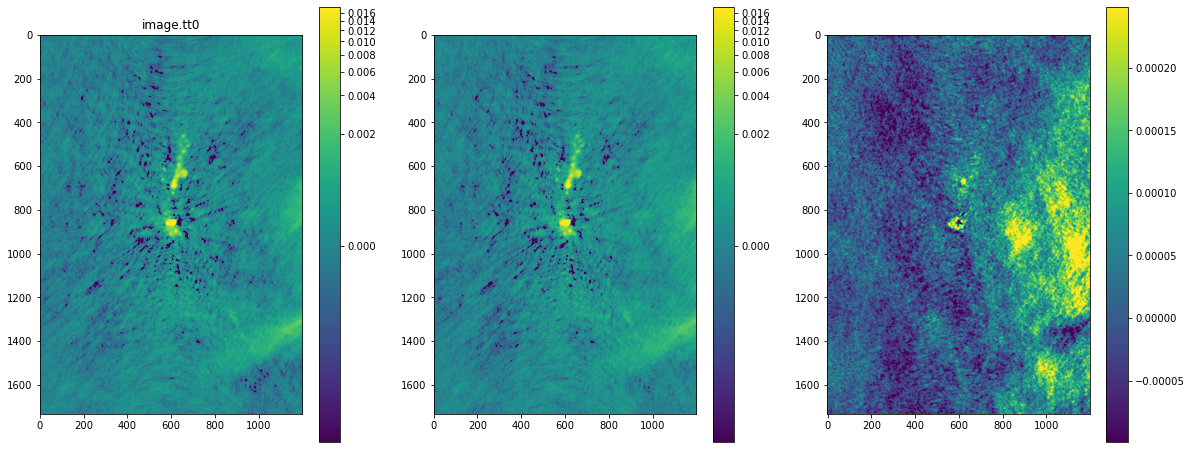

In [16]:
cutoutregion = 'fk5; box(19:23:43.93,+14:30:34.8,45",65")'

pl.figure(figsize=(20,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
ax1 = pl.subplot(1,3,1)
ax1.imshow(image[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax1.set_title("image.tt0")
ax2 = pl.subplot(1,3,2)
im2 = pipe_image.subcube_from_ds9region(cutoutregion)
ax2.imshow(im2[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax3 = pl.subplot(1,3,3)
im3 = im2[0].value-image[0].value
ax3.imshow(im3, norm=simple_norm(im3, max_percent=99, min_percent=1, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])

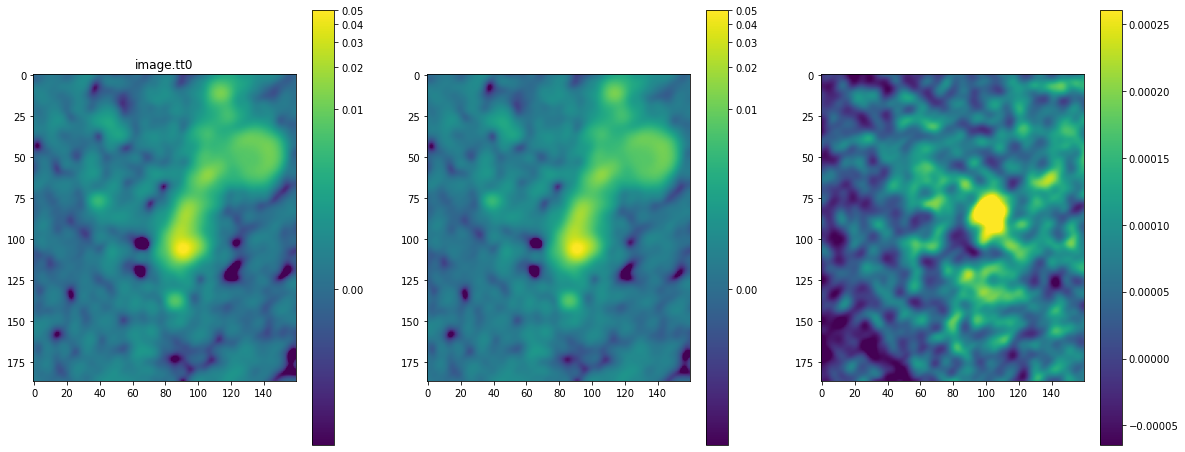

In [22]:
cutoutregion = 'fk5; box(19:23:43.93,+14:30:27.8,6",7")'

pl.figure(figsize=(20,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
ax1 = pl.subplot(1,3,1)
ax1.imshow(image[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax1.set_title("image.tt0")
ax2 = pl.subplot(1,3,2)
im2 = pipe_image.subcube_from_ds9region(cutoutregion)
ax2.imshow(im2[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax3 = pl.subplot(1,3,3)
im3 = im2[0].value-image[0].value
ax3.imshow(im3, norm=simple_norm(im3, max_percent=99, min_percent=1, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])

In [38]:
ls -d imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms*

imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.alpha/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.alpha.error/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.alpha.pbcor/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.image.tt0/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.image.tt0.pbcor/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.image.tt1/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.image.tt1.pbcor/
imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_clean.mask/
imaging_results/W51-E_B3_uid___A0

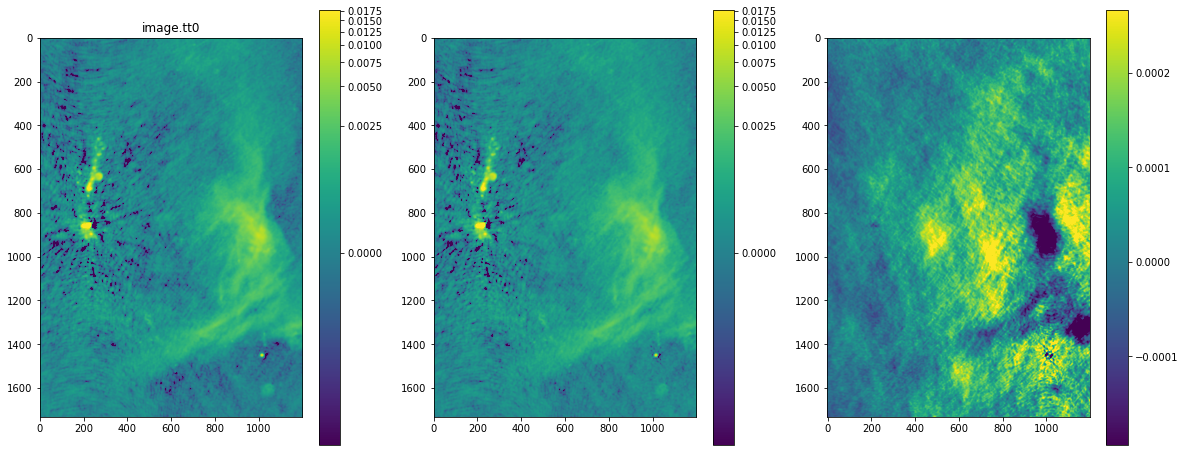

In [41]:
finaliter_prefix = "imaging_results/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter_dec17ms_dirty"
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)

cutoutregion = 'fk5; box(19:23:42.93,+14:30:34.8,45",65")'

pl.figure(figsize=(20,8))
image = SpectralCube.read(f'{finaliter_prefix}.image.tt0', format='casa_image').subcube_from_ds9region(cutoutregion)
ax1 = pl.subplot(1,3,1)
ax1.imshow(image[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax1.set_title("image.tt0")
ax2 = pl.subplot(1,3,2)
im2 = pipe_image.subcube_from_ds9region(cutoutregion)
ax2.imshow(im2[0].value, norm=simple_norm(image[0].value, max_percent=99.95, min_percent=1, stretch='log')); pl.colorbar(mappable=pl.gca().images[0])
ax3 = pl.subplot(1,3,3)
im3 = im2[0].value-image[0].value
ax3.imshow(im3, norm=simple_norm(im3, max_percent=99, min_percent=1, stretch='linear')); pl.colorbar(mappable=pl.gca().images[0])